# Featurisation and model tuning

Semiconductor manufacturing process

## Data Description

> (1567, 592)

The data consists of 1567 datapoints each with 591 features. The dataset presented in this case represents a selection of such features where each example represents a single production entity with associated measured features and the labels represent a simple pass/fail yield for in house line testing. Target column "-1" corresponds to a pass and "1" corresponds to a fail and the data time stamp is for that specific test point.

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from imblearn.over_sampling import SMOTE
from sklearn.decomposition import PCA

from sklearn.metrics import f1_score
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import balanced_accuracy_score

from sklearn.feature_selection import SelectFromModel
from sklearn.feature_selection import SelectKBest

from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler

from imblearn.pipeline import Pipeline as imbpipeline

from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import LeaveOneOut
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV

from sklearn.ensemble import ExtraTreesClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import AdaBoostClassifier
from sklearn.svm import LinearSVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier

sns.set()

In [2]:
import warnings

warnings.filterwarnings("ignore")

### Import and understand the data

In [3]:
df = pd.read_csv("data/signal-data.csv")

In [4]:
df.head()

,Time,0,1,2,3,4,5,6,7,8,...,581,582,583,584,585,586,587,588,589,Pass/Fail
0,2008-07-19 11:55:00,3030.93,2564.00,2187.7333,1411.1265,1.3602,100.0,97.6133,0.1242,1.5005,...,NaN,0.5005,0.0118,0.0035,2.3630,NaN,NaN,NaN,NaN,-1
1,2008-07-19 12:32:00,3095.78,2465.14,2230.4222,1463.6606,0.8294,100.0,102.3433,0.1247,1.4966,...,208.2045,0.5019,0.0223,0.0055,4.4447,0.0096,0.0201,0.0060,208.2045,-1
2,2008-07-19 13:17:00,2932.61,2559.94,2186.4111,1698.0172,1.5102,100.0,95.4878,0.1241,1.4436,...,82.8602,0.4958,0.0157,0.0039,3.1745,0.0584,0.0484,0.0148,82.8602,1
3,2008-07-19 14:43:00,2988.72,2479.90,2199.0333,909.7926,1.3204,100.0,104.2367,0.1217,1.4882,...,73.8432,0.4990,0.0103,0.0025,2.0544,0.0202,0.0149,0.0044,73.8432,-1
4,2008-07-19 15:22:00,3032.24,2502.87,2233.3667,1326.5200,1.5334,100.0,100.3967,0.1235,1.5031,...,NaN,0.4800,0.4766,0.1045,99.3032,0.0202,0.0149,0.0044,73.8432,-1


In [5]:
df.shape

(1567, 592)

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1567 entries, 0 to 1566
Columns: 592 entries, Time to Pass/Fail
dtypes: float64(590), int64(1), object(1)
memory usage: 7.1+ MB


In [7]:
summary = df.describe().T
summary

,count,mean,std,min,25%,50%,75%,max
0,1561.0,3014.452896,73.621787,2743.2400,2966.260000,3011.4900,3056.6500,3356.3500
1,1560.0,2495.850231,80.407705,2158.7500,2452.247500,2499.4050,2538.8225,2846.4400
2,1553.0,2200.547318,29.513152,2060.6600,2181.044400,2201.0667,2218.0555,2315.2667
3,1553.0,1396.376627,441.691640,0.0000,1081.875800,1285.2144,1591.2235,3715.0417
4,1553.0,4.197013,56.355540,0.6815,1.017700,1.3168,1.5257,1114.5366
...,...,...,...,...,...,...,...,...
586,1566.0,0.021458,0.012358,-0.0169,0.013425,0.0205,0.0276,0.1028
587,1566.0,0.016475,0.008808,0.0032,0.010600,0.0148,0.0203,0.0799
588,1566.0,0.005283,0.002867,0.0010,0.003300,0.0046,0.0064,0.0286
589,1566.0,99.670066,93.891919,0.0000,44.368600,71.9005,114.7497,737.3048


In [8]:
min(summary["min"])

-14804.5

In [9]:
max(summary["max"])

37943.0

Since there are more than 500 features (signal types) we'll take only few signal types for our observations

Note: Since the signals aren't labelled. We only have the numbers as labels.

- In **signal 0** the range of value is from 2743.24 to 3356.35 but in the case of **signal 3** the range is from 0 to 3715.04
- This suggests that the minimum value of the signals aren't starting from 0 and we might not be able to put a bar unless we have more context
	- The minimum of the all the minimum value goes to as much as -14804.5 and maximum of all max values can also go upto 37943.0

- It can be observed from **signals 587 and 588** that signal values are also be very minute in the range of 0 to 1

### Data cleansing

In [10]:
df_len = len(df)
result = {
    "column_name": [],
    "percent_null_value": [],
    "number_of_null_values": [],
    "operation": [],
}

for column in df.columns:
    number_of_null_values = df[column].isnull().sum()
    percentage_null_value = (number_of_null_values / df_len) * 100
    result["column_name"].append(column)
    result["percent_null_value"].append(percentage_null_value)
    result["number_of_null_values"].append(number_of_null_values)
    operation = "no operation"
    if percentage_null_value > 20.0:
        df.drop(column, axis=1, inplace=True)
        operation = "column_dropped"
    elif number_of_null_values > 0:
        df[column].fillna(df[column].mean(), axis=0, inplace=True)
        operation = "imputed with mean"
    else:
        pass
    result["operation"].append(operation)
result_df = pd.DataFrame(result)

In [11]:
result_df.sample(10)

,column_name,percent_null_value,number_of_null_values,operation
563,562,17.421825,273,imputed with mean
176,175,0.063816,1,imputed with mean
149,148,0.127632,2,imputed with mean
366,365,0.127632,2,imputed with mean
588,587,0.063816,1,imputed with mean
457,456,0.063816,1,imputed with mean
135,134,0.510530,8,imputed with mean
582,581,60.561583,949,column_dropped
520,519,45.628590,715,column_dropped
178,177,0.063816,1,imputed with mean


In [12]:
df[df.duplicated()]

,Time,0,1,2,3,4,5,6,7,8,...,577,582,583,584,585,586,587,588,589,Pass/Fail


> Note: Looks like there are no duplicate rows but we'll anyway remove duplicates with **drop_duplicates**

In [13]:
df.drop_duplicates(inplace=True)

In [14]:
# We'll drop the 'Time' column since it won't be used since time as a feature won't affect the manufacturing process.

df.drop("Time", axis=1, inplace=True)

In [15]:
# Getting a clean df before performing any more operations. Can be used later to try other techniques

df_clean = df.copy(deep=True)

In [16]:
summary[summary["std"] == 0]

,count,mean,std,min,25%,50%,75%,max
5,1553.0,100.0,0.0,100.0,100.0,100.0,100.0,100.0
13,1564.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
42,1566.0,70.0,0.0,70.0,70.0,70.0,70.0,70.0
49,1566.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0
52,1566.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...
534,1558.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
535,1558.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
536,1558.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
537,1558.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Features with a standard deviation of 0 means that all its values are the same. This means the feature does not contain any information or variation that can be used to predict the target variable. Hence, such features are not useful and the columns can be dropped.

In [17]:
# sklearn.feature_selection.VarianceThreshold can be used? need to check

# Iterate and drop columns with std value as 0
for column in df.columns:
    if df[column].std() == 0:
        df.drop(column, axis=1, inplace=True)

In [18]:
df.shape

(1567, 443)

In [19]:
# threshold = 0.95
# correlation_matrix = df.corr()
# high_corr = np.where(np.abs(correlation_matrix) > threshold)

# print the first two elements to check the correlation structure
# print(high_corr[0][0:20])
# print(high_corr[1][0:20])
# correlated_column_pairs = [
#     (correlation_matrix.index[x], correlation_matrix.columns[y])
#     for x, y in zip(*high_corr)
#     if x != y
# ]

In [20]:
def get_correlated_columns(df, threshold):
    correlated_columns = []
    correlation_matrix = df.corr()
    for i in range(len(correlation_matrix.columns)):
        for j in range(i):
            if (
                abs(correlation_matrix.iloc[i, j]) > threshold
            ):  # can be negative/positive so we'll use abs
                # name of column appended
                # only column (i) appended
                correlated_columns.append(correlation_matrix.columns[i])
                # print(i,j)
    return list(set(correlated_columns))


correlated_features = get_correlated_columns(df, threshold=0.95)
correlated_features[0:5]

['440', '388', '140', '106', '436']

In [21]:
len(correlated_features)

173

In [22]:
df.drop(correlated_features, axis=1, inplace=True)

In [23]:
df.shape

(1567, 270)

**Observation** 

If two features are collinear, they shouldn't be considered together. A threshold of **0.95** above which (173) columns are dropped. 

In [24]:
X = df.drop("Pass/Fail", axis=1)
y = df["Pass/Fail"].astype("category").cat.codes

In [25]:
X.shape

(1567, 269)

In [26]:
y.value_counts()

0    1463
1     104
dtype: int64

In [27]:
correlation_with_target = X.corrwith(y)

# Set threshold to 0.05 (there is no specific rule to set the threshold)
threshold = 0.05
low_correlation_features = correlation_with_target[
    np.abs(correlation_with_target) < threshold
].index

In [28]:
len(low_correlation_features)

208

In [29]:
X.drop(low_correlation_features, axis=1, inplace=True)

In [30]:
# re-construct the df

df = X
df["Pass/Fail"] = y

In [31]:
df.shape

(1567, 62)

- SelectFromModel is a meta-transformer that can be used alongside any estimator that assigns importance to each feature through a specific attribute.
- The features are considered unimportant and removed if the corresponding importance of the feature values are below the provided threshold parameter.
- **SelectFromModel** automatically calculates the threshold value based on mean/medain of the feature importances or coefficients if not provided.

In [32]:
# Reference - https://scikit-learn.org/stable/auto_examples/ensemble/plot_forest_importances.html#sphx-glr-auto-examples-ensemble-plot-forest-importances-py
X = df.drop("Pass/Fail", axis=1)
y = df["Pass/Fail"]

clf = ExtraTreesClassifier(n_estimators=50, random_state=13).fit(X, y)
model = SelectFromModel(clf, prefit=True)
# model = SelectFromModel(clf, threshold=0.015, prefit=True)
X_new = model.transform(X)
X_new.shape

(1567, 21)

In [33]:
# Re-create the df
df = pd.DataFrame(X_new, columns=X.columns[model.get_support()])
df["Pass/Fail"] = y

In [34]:
df.sample(10)

,32,38,40,59,63,64,65,68,70,100,...,166,205,210,337,348,460,471,510,551,Pass/Fail
289,84.3232,87.0459,78.42,17.9782,16.3736,22.0218,29.1850,146.9073,607.6764,-0.0002,...,2.9,11.68,0.0726,0.8894,0.0183,27.8636,6.2387,57.0629,0.620000,0
1187,86.7559,87.0029,76.87,1.4055,13.2709,18.5945,21.2995,146.9045,611.2073,-0.0003,...,2.9,10.50,0.0712,5.1166,0.0168,20.6732,31.3633,41.5902,0.980000,0
705,85.7833,86.5639,76.61,4.0555,9.6396,15.9445,18.2770,151.4891,618.6591,0.0002,...,3.0,6.61,0.1490,3.7386,0.0416,27.2044,29.0995,58.0357,1.320000,0
155,84.8180,86.7969,78.31,-3.2509,11.1138,23.2509,32.6343,147.0755,634.1618,0.0000,...,2.6,10.79,0.1068,1.0653,0.0272,26.9323,3.4222,142.6901,0.830000,0
559,83.6359,87.2000,66.12,-0.4173,11.4469,20.4173,27.1259,145.7555,632.7045,0.0001,...,2.7,14.48,0.0900,1.3416,0.0254,21.3212,11.2056,34.1801,0.400000,0
452,85.7103,87.1828,79.59,2.2118,12.1947,17.7882,23.5681,145.7764,620.3418,0.0000,...,2.2,4.94,0.0510,1.4154,0.0131,18.5910,8.9522,67.8840,1.150000,0
835,84.3610,86.3364,81.74,7.0273,11.7043,12.9727,16.5255,143.7555,609.7309,-0.0001,...,2.9,5.34,0.0767,2.0671,0.0224,19.2024,6.0961,25.4835,0.750000,0
869,85.5246,87.3204,10.11,5.9155,12.9509,14.0845,19.9683,145.3418,616.3182,-0.0006,...,1.2,8.09,0.1069,0.9888,0.0317,21.7408,5.4538,35.6998,0.810000,0
1007,84.5987,86.8182,79.35,4.9082,8.7316,15.0918,19.7445,148.2364,616.1045,-0.0006,...,4.9,4.50,0.0533,1.6419,0.0132,73.4752,5.2310,33.1688,1.230712,0
1177,85.9801,86.2277,81.32,-0.9500,21.2546,20.9500,31.2129,144.5627,618.1018,0.0003,...,2.2,6.28,0.1228,2.6885,0.0281,19.8503,6.5505,40.1180,2.140000,0


In [35]:
df.shape

(1567, 22)

### Data analysis & visualisation

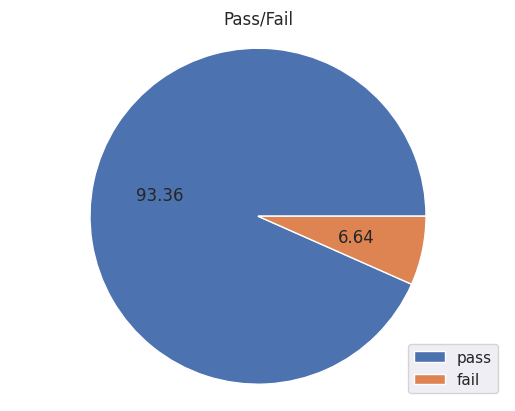

In [36]:
pass_fail_dist = df["Pass/Fail"].value_counts(normalize=True)
plt.pie(pass_fail_dist, autopct="%.2f")
plt.title("Pass/Fail")
plt.legend(loc="lower right", labels=["pass", "fail"])
plt.axis("equal")
plt.show()

**Observation** 

Majority of cases are "PASS" for a sensor but very less number of data is available to identify "FAIL" cases.
This shows that classes are not balanced.

In [37]:
chosen_columns = list(df.columns[0:5]) + ["Pass/Fail"]
chosen_columns

['32', '38', '40', '59', '63', 'Pass/Fail']

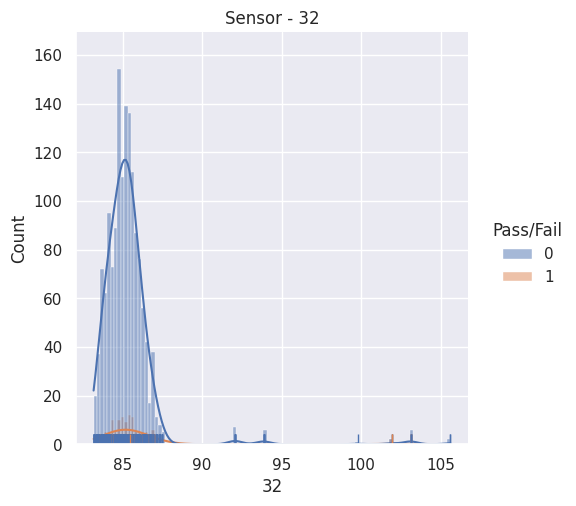

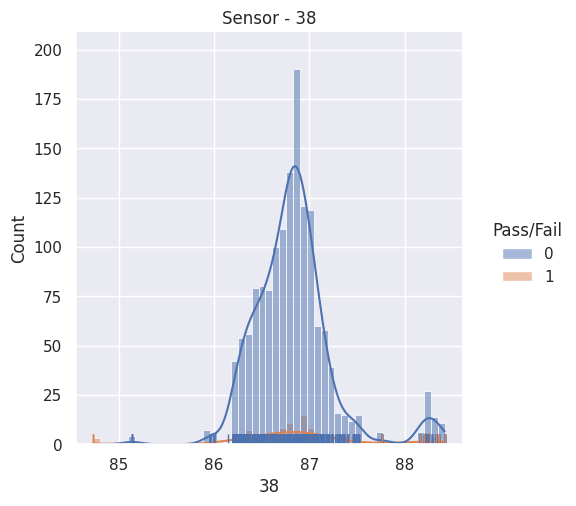

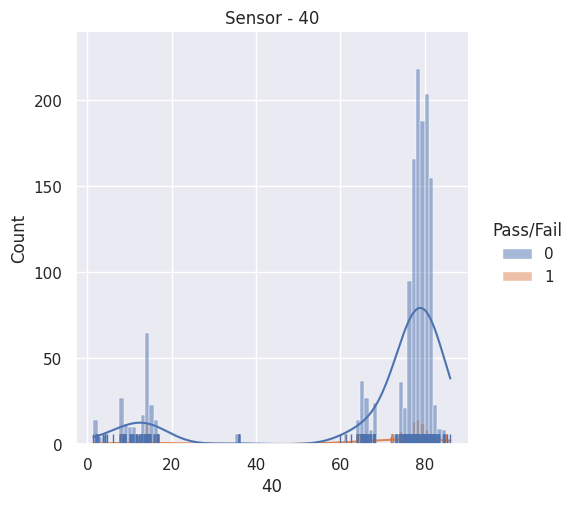

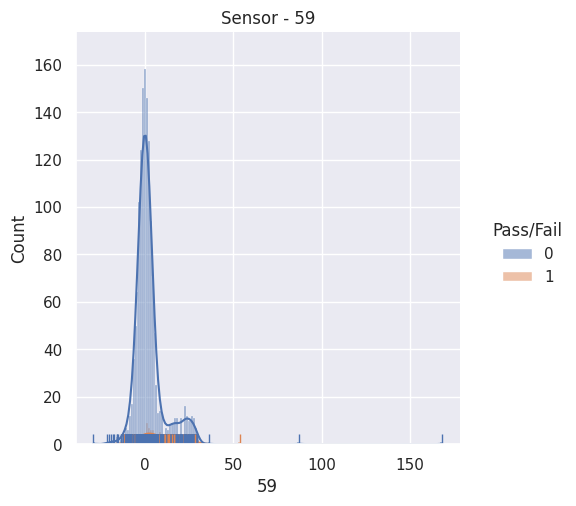

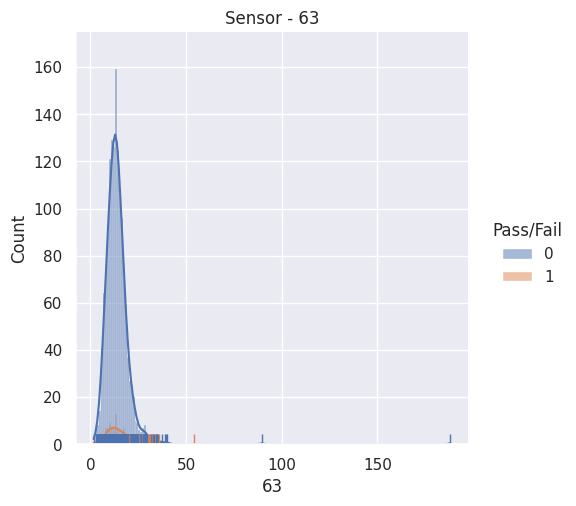

In [38]:
for column in df[chosen_columns].columns[0:5]:
    sns.displot(
        df[chosen_columns], x=column, hue="Pass/Fail", kind="hist", rug=True, kde=True
    )
    plt.title(f"Sensor - {column}")
    plt.show()

**Observation**

> We'll take first 5 sensor values for uni-variate analysis

- Sensor 32, 58 and 59 are right skewed and for sensor 40, the distribution is left skewed but there is no clear relation in outliers observed with "FAIL" cases.
- Except for sensor 59 the minimum signal values are above 0 for selected 5 sensors.
- In the case of sensor 38 there ain't much variation in the value

Bivariate and multivariate analysis with appropriate detailed comments after each analysis.

<AxesSubplot: xlabel='32', ylabel='38'>

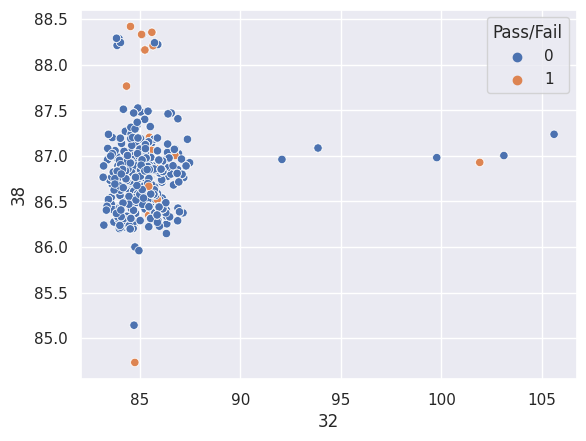

In [39]:
sns.scatterplot(df, x="32", y="38", hue="Pass/Fail")

<AxesSubplot: xlabel='38', ylabel='59'>

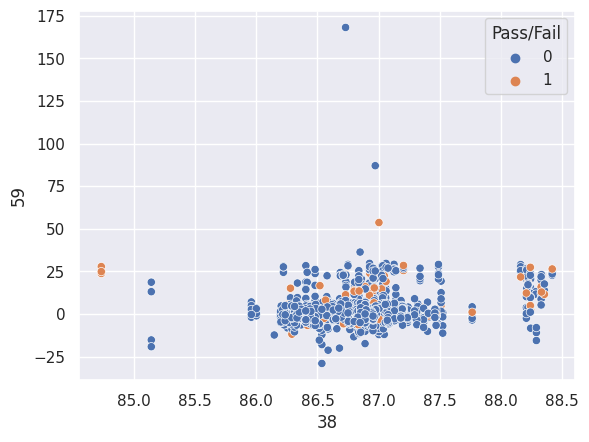

In [40]:
sns.scatterplot(df, x="38", y="59", hue="Pass/Fail")

<AxesSubplot: xlabel='59', ylabel='40'>

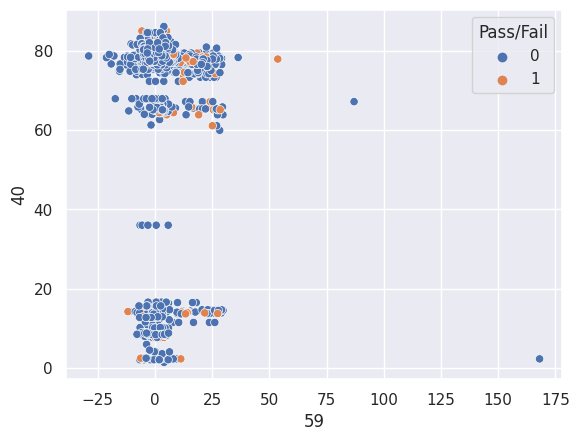

In [41]:
sns.scatterplot(df, x="59", y="40", hue="Pass/Fail")

**Observations**

> Note: Since we don't have variable names here, it is difficult to understand which variable is giving us what information
> Therefore bi-variate analysis of few variables are perfomed here.

- There doesn't seem to be a linear pattern	/correlation between the selected sensor data. They appear to be clustered. 
- The scatter plot between sensor 38 and 58 shows comparatively better correlation to the other scatter plots 

<AxesSubplot: >

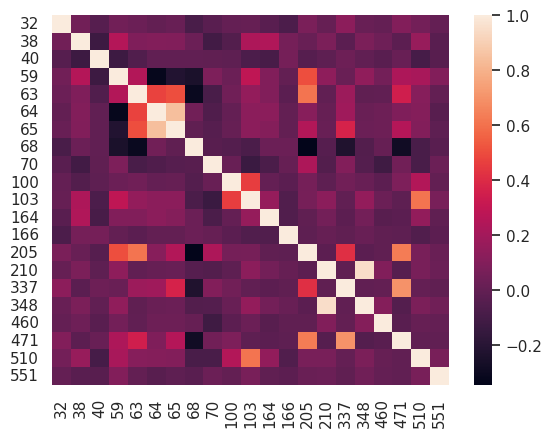

In [42]:
# sns.heatmap(df[chosen_columns].drop('Pass/Fail', axis=1).corr(), annot=True)
sns.heatmap(df.drop("Pass/Fail", axis=1).corr())

**Observation**

- There are are points which are both negatively and positively correlated.
	- Example between sensor data 210 and 348 for positive correlation and 68 and 205 for strong negative correlation.
- In most of the cases the correlation value ranges from -0.2 to 0.2

### Data pre-processing

In [43]:
# predictor
X = df.drop("Pass/Fail", axis=1)

# target
y = df["Pass/Fail"]

In [44]:
pass_count, fail_count = y.value_counts()
print(f"Pass count - {pass_count}")
print(f"Fail count - {fail_count}")

Pass count - 1463
Fail count - 104


In [45]:
# Oversampling minority class without using imblearn package


# df_pass = df[df['Pass/Fail'] == 0]
# df_fail = df[df['Pass/Fail'] == 1]

# df_fail_over_sample = df_fail.sample(pass_count, replace=True)
# df_sampled = pd.concat([df_pass, df_fail_over_sample], axis=0)

# df_sampled['Pass/Fail'].value_counts()

In [46]:
sm = SMOTE(sampling_strategy="minority", random_state=13)

X, y = sm.fit_resample(X, y)
y.value_counts()

0    1463
1    1463
Name: Pass/Fail, dtype: int64

SMOTE creates synthetic samples of the minority class by interpolating between existing minority samples, while random upsampling simply duplicates existing minority samples. This makes SMOTE less prone to overfitting compared to random upsampling.

In [47]:
scaler = MinMaxScaler()
scaler.fit(X)
X_scaled = pd.DataFrame(scaler.transform(X), columns=X.columns)
X_scaled.shape

(2926, 21)

In [48]:
X_scaled.sample(5)

,32,38,40,59,63,64,65,68,70,100,...,164,166,205,210,337,348,460,471,510,551
321,0.106200,0.631508,0.737147,0.243951,0.059890,0.339659,0.198388,0.718471,0.343264,0.603774,...,0.037975,0.103448,0.024296,0.346956,0.086847,0.251311,0.113405,0.005986,0.058797,0.028327
1513,0.081977,0.422289,0.922774,0.171181,0.030111,0.206735,0.136624,0.818059,0.356588,0.566038,...,0.076500,0.167488,0.026404,0.152941,0.057877,0.082499,0.121210,0.017155,0.093137,0.030859
1025,0.036140,0.601530,0.900338,0.162198,0.027521,0.248364,0.162657,0.763674,0.248646,0.339623,...,0.015960,0.241379,0.020740,0.105263,0.033314,0.077730,0.078092,0.007061,0.078245,0.019128
738,0.016770,0.614471,0.931394,0.164494,0.069199,0.237722,0.170489,0.791700,0.185253,0.641509,...,0.074298,0.157635,0.056428,0.111455,0.028792,0.062470,0.134343,0.017598,0.075902,0.027034
2677,0.065869,0.461107,0.938463,0.137835,0.047890,0.361263,0.214682,0.687695,0.284746,0.672667,...,0.028891,0.107945,0.014349,0.079875,0.088457,0.052893,0.018868,0.065983,0.071641,0.008255


In [49]:
# Wrong way! Split and then standardize :)
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=13, shuffle=True, stratify=y
)
print(f"X_train shape - {X_train.shape}")
print(f"X_test shape  - {X_test.shape}")
print(f"y_train len   - {len(y_train)}")
print(f"y_test len    - {len(y_test)}")

X_train shape - (2340, 21)
X_test shape  - (586, 21)
y_train len   - 2340
y_test len    - 586


Printing the 5 point summary for only the first 10 elements to verify

In [50]:
X_scaled.describe().T.head(10)

,count,mean,std,min,25%,50%,75%,max
32,2926.0,0.100842,0.088899,0.0,0.066434,0.089163,0.113864,1.0
38,2926.0,0.581015,0.137096,0.0,0.506792,0.570163,0.625643,1.0
40,2926.0,0.761727,0.296601,0.0,0.784910,0.902851,0.926080,1.0
59,2926.0,0.173697,0.049148,0.0,0.143246,0.159313,0.195221,1.0
63,2926.0,0.069069,0.036234,0.0,0.048399,0.063362,0.081315,1.0
64,2926.0,0.342909,0.136743,0.0,0.252093,0.322024,0.407072,1.0
65,2926.0,0.204934,0.065847,0.0,0.163196,0.194852,0.234893,1.0
68,2926.0,0.744443,0.053837,0.0,0.718159,0.745816,0.775625,1.0
70,2926.0,0.260013,0.064279,0.0,0.220122,0.257651,0.300768,1.0
100,2926.0,0.569608,0.066805,0.0,0.529189,0.566038,0.603774,1.0


In [51]:
X_train.describe().T.head(10)

,count,mean,std,min,25%,50%,75%,max
32,2340.0,0.101254,0.090525,0.000000,0.066434,0.089148,0.113897,1.000000
38,2340.0,0.580918,0.138007,0.000000,0.509467,0.571091,0.626616,1.000000
40,2340.0,0.761599,0.297260,0.000000,0.784910,0.902877,0.926080,0.991498
59,2340.0,0.174355,0.050085,0.000000,0.143656,0.159639,0.196811,1.000000
63,2340.0,0.068956,0.037123,0.000000,0.048390,0.063267,0.081300,1.000000
64,2340.0,0.341188,0.135727,0.004252,0.250498,0.319817,0.404661,1.000000
65,2340.0,0.204380,0.066580,0.000000,0.162528,0.194659,0.232724,1.000000
68,2340.0,0.744515,0.054306,0.105704,0.718209,0.746191,0.775879,1.000000
70,2340.0,0.259947,0.064496,0.006816,0.220110,0.256651,0.300781,1.000000
100,2340.0,0.569362,0.066903,0.000000,0.529149,0.566038,0.603774,1.000000


In [52]:
X_test.describe().T.head(10)

,count,mean,std,min,25%,50%,75%,max
32,586.0,0.099197,0.082139,0.001004,0.066452,0.090415,0.113657,0.888693
38,586.0,0.581399,0.133511,0.007455,0.501370,0.567102,0.621409,1.000000
40,586.0,0.762238,0.294209,0.008171,0.784910,0.902574,0.926552,1.000000
59,586.0,0.171068,0.045160,0.039479,0.141457,0.158324,0.190726,0.419360
63,586.0,0.069521,0.032465,0.010430,0.048592,0.063545,0.081741,0.280454
64,586.0,0.349779,0.140640,0.000000,0.257132,0.327603,0.423051,0.984121
65,586.0,0.207146,0.062842,0.039161,0.167535,0.195757,0.239007,0.462212
68,586.0,0.744155,0.051969,0.000000,0.718102,0.743634,0.774715,0.857768
70,586.0,0.260279,0.063456,0.000000,0.220620,0.261968,0.300316,0.420381
100,586.0,0.570589,0.066459,0.113208,0.529446,0.566038,0.603774,0.981132


**Observation**

- It can be observed that the standard deviation and mean values of X_scaled, X_train and X_test are similar

In [53]:
def plot_distributions(train, test, feature):
    plt.hist(train[feature], bins=50, alpha=0.5, label="Train")
    plt.hist(test[feature], bins=50, alpha=0.5, label="Test")
    plt.legend(loc="upper right")
    plt.title("Distribution of Feature: " + feature)
    plt.xlabel("Value")
    plt.ylabel("Frequency")
    plt.show()

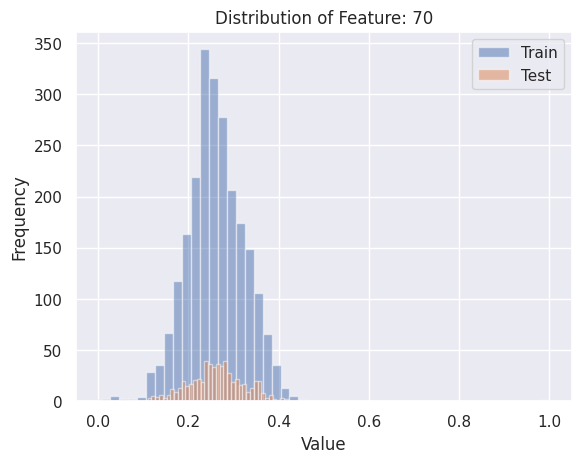

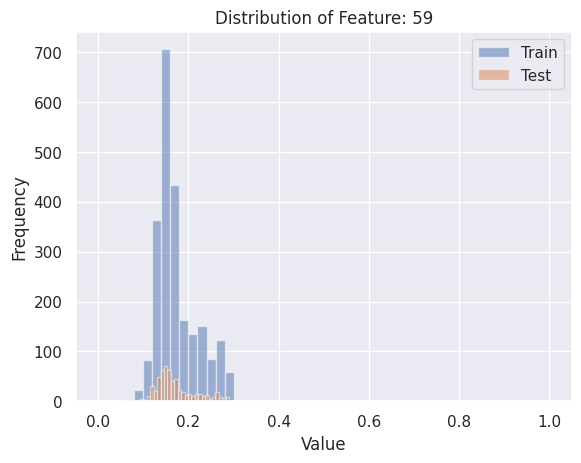

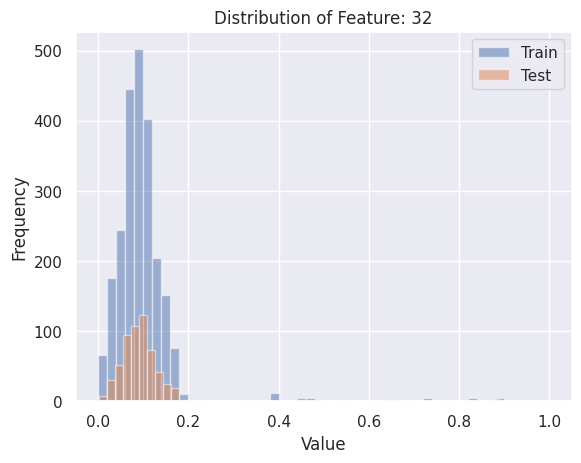

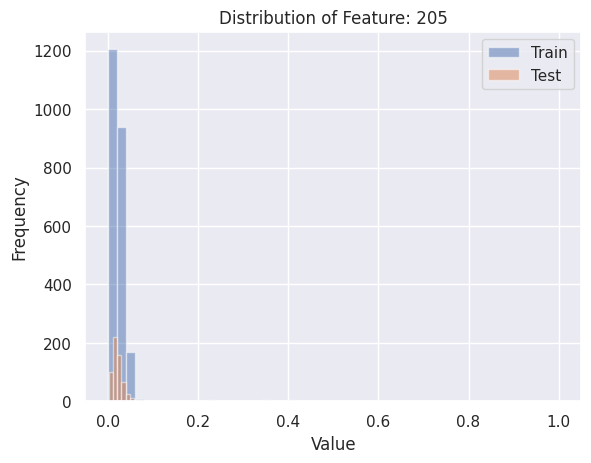

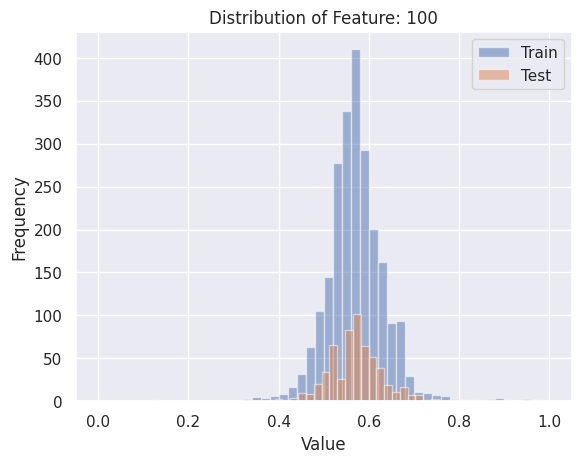

In [54]:
for column in pd.Series(X_train.columns).sample(5):
    plot_distributions(X_train, X_test, column)

Randomly picked 5 features to visualize the train test distribution

It can be observed that these distributions are similar suggesting that the train-test split is representative of the overall data distribution

### Model training, testing and tuning

In [55]:
log_reg_model = LogisticRegression(random_state=13)
log_reg_model.fit(X_train, y_train)
log_reg_model.score(X_test, y_test)

0.7064846416382252

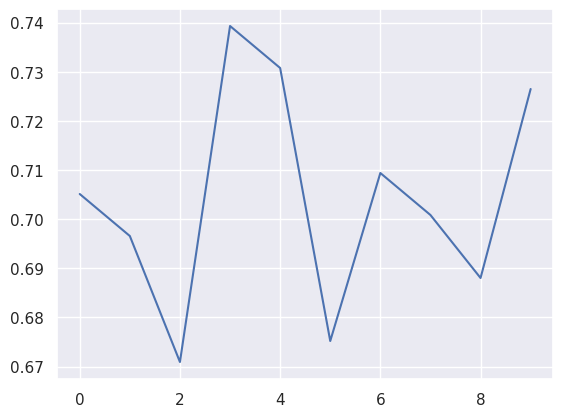

KFold score mean - 0.7042735042735042 



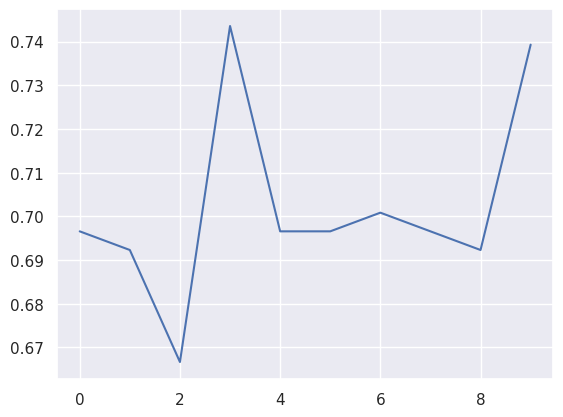

StratifiedKFold score mean - 0.7021367521367521 



In [56]:
n_splits = 10
scores = {}
model = LogisticRegression(random_state=13)
for technique in [KFold(n_splits=n_splits), StratifiedKFold(n_splits=n_splits)]:
    results = cross_val_score(model, X_train, y_train, cv=technique)
    technique_name = technique.__class__.__name__
    scores[technique_name] = results
    sns.lineplot(results)
    plt.show()
    print(f"{technique_name} score mean - {np.mean(results)} \n")

In [57]:
scores

{'KFold': array([0.70512821, 0.6965812 , 0.67094017, 0.73931624, 0.73076923,
        0.67521368, 0.70940171, 0.7008547 , 0.68803419, 0.72649573]),
 'StratifiedKFold': array([0.6965812 , 0.69230769, 0.66666667, 0.74358974, 0.6965812 ,
        0.6965812 , 0.7008547 , 0.6965812 , 0.69230769, 0.73931624])}

In [58]:
# Leave One out cross validation
results = cross_val_score(model, X_train, y_train, cv=LeaveOneOut())
np.mean(results)

0.6982905982905983

In [59]:
clf = LogisticRegression()
param_dist = {
    "penalty": ["l1", "l2", "elasticnet", "none"],
    "C": [0.01, 0.1, 0.5, 1, 10, 100],
    "fit_intercept": [True, False],
    "solver": ["newton-cg", "lbfgs", "liblinear", "sag", "saga"],
}

random_cv = RandomizedSearchCV(
    clf,
    param_distributions=param_dist,
    n_iter=100,
    cv=5,
    scoring="accuracy",
    verbose=1,
    random_state=13,
)

random_cv.fit(X_train, y_train)

Fitting 5 folds for each of 100 candidates, totalling 500 fits


RandomizedSearchCV(cv=5, estimator=LogisticRegression(), n_iter=100,
                   param_distributions={'C': [0.01, 0.1, 0.5, 1, 10, 100],
                                        'fit_intercept': [True, False],
                                        'penalty': ['l1', 'l2', 'elasticnet',
                                                    'none'],
                                        'solver': ['newton-cg', 'lbfgs',
                                                   'liblinear', 'sag',
                                                   'saga']},
                   random_state=13, scoring='accuracy', verbose=1)

In [60]:
print("RandomSearchCV")
print(f"Best params  - {random_cv.best_params_}")
print(f"Best score   - {random_cv.best_score_}")

RandomSearchCV
Best params  - {'solver': 'saga', 'penalty': 'l1', 'fit_intercept': True, 'C': 0.5}
Best score   - 0.711111111111111


In [61]:
grid_search = GridSearchCV(clf, param_dist, cv=5, scoring="accuracy")
grid_search.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=LogisticRegression(),
             param_grid={'C': [0.01, 0.1, 0.5, 1, 10, 100],
                         'fit_intercept': [True, False],
                         'penalty': ['l1', 'l2', 'elasticnet', 'none'],
                         'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag',
                                    'saga']},
             scoring='accuracy')

In [62]:
print("GridSearchCV")
print(f"Best params  - {grid_search.best_params_}")
print(f"Best score   - {grid_search.best_score_}")

GridSearchCV
Best params  - {'C': 0.5, 'fit_intercept': True, 'penalty': 'l1', 'solver': 'saga'}
Best score   - 0.711111111111111


Note: After exploring GridSearchCV the best parameters seem to be the same as one foudn with RandomSearchCV.

The initial 500+ features are alerady reduced down to 21 features but we'll be using the original data (**df_clean**) to try other methods. 

We can attempt to apply methods from **sklearn.feature_selection** and other techniques to see if we find some more improvement in the model performance on the original data.

In [63]:
df_clean.shape

(1567, 559)

In [64]:
X = df_clean.drop("Pass/Fail", axis=1)
y = df_clean["Pass/Fail"].astype("category").cat.codes

In [65]:
X.shape

(1567, 558)

In [66]:
# Using StandardScaler instead of MinMaxScaler

scaler = StandardScaler()
scaler.fit(X)
X_scaled = pd.DataFrame(scaler.transform(X), columns=X.columns)

X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=13, shuffle=True, stratify=y
)

model = LogisticRegression(random_state=13)
model.fit(X_train, y_train)
model.score(X_test, y_test)

0.8598726114649682

In [67]:
def get_cross_val_score(model, X, y, splits=10):
    results = cross_val_score(model, X, y, cv=StratifiedKFold(n_splits=splits))
    return round(np.mean(results), 2)

In [68]:
get_cross_val_score(model, X_train, y_train)

0.89

In [69]:
y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.94      0.91      0.92       293
           1       0.10      0.14      0.12        21

    accuracy                           0.86       314
   macro avg       0.52      0.53      0.52       314
weighted avg       0.88      0.86      0.87       314



**Observation**

Although the oevrall accuracy shoots up. The predictor does not perform well in comes to **class 1**

We'll need to balance the class with SMOTE like done previously

**SelectKBest** feature selection method that selects the top K features with the highest scores. The score function used here is f-classif by default. 

The score function computes a score that measures the relationship between the feature and the target variable, then selects the features with the highest scores to keep in the model. The number of features to keep is specified by the user with the parameter k.

In [70]:
sm = SMOTE(sampling_strategy="minority", random_state=13)

X, y = sm.fit_resample(X_scaled, y)
y.value_counts()

0    1463
1    1463
dtype: int64

In [71]:
selector = SelectKBest(k=20)
X_new = selector.fit_transform(X, y)

X_scaled.columns[selector.get_support()]

Index(['28', '30', '56', '59', '79', '80', '103', '121', '122', '123', '124',
       '125', '127', '129', '130', '133', '280', '348', '468', '510'],
      dtype='object')

In [72]:
X_new.shape

(2926, 20)

In [73]:
X_train, X_test, y_train, y_test = train_test_split(
    X_new, y, test_size=0.2, random_state=13, shuffle=True, stratify=y
)
model.fit(X_train, y_train)

get_cross_val_score(model, X_train, y_train)

0.72

In [74]:
get_cross_val_score(model, X_test, y_test)

0.75

In [75]:
# Try using PCA instead of SelectKBest
# We'll choose 20 components to see the results

pca_new = PCA(n_components=20)
pca_new.fit(X)
X_pca = pca_new.transform(X)
X_train, X_test, y_train, y_test = train_test_split(
    X_pca, y, test_size=0.2, random_state=13, stratify=y
)
model.fit(X_train, y_train)
get_cross_val_score(model, X_train, y_train)

0.69

**Observation**

- Using **SelectKBest** to select 20 features along with StandardScaler has improved the accuracy by ~2%.
	- Also we've quickly reduced our features to 20 with better results compared to removing them based on standard deviation, correlation and using SelectFromModel meta-transformer
- There wasn't much improvement noticed in accuracy on using PCA.

In [76]:
X_train, X_test, y_train, y_test = train_test_split(
    X_new, y, test_size=0.2, random_state=13, shuffle=True, stratify=y
)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.75      0.72      0.74       293
           1       0.73      0.76      0.75       293

    accuracy                           0.74       586
   macro avg       0.74      0.74      0.74       586
weighted avg       0.74      0.74      0.74       586



**Observation**

- The precision and recall score for both the classes are balanced. 
- The f1-score which is an idicator of balance between precision and recall is 0.74 (weighted average)
- We can try other classification models to see if there are any more improvements

Note: Since all intermediate steps should be transformers and implement fit and transform (for SMOTE) in the case of sklearn's pipeline we'll be using imblearn's Pipeline class to fix this.

In [77]:
X = df_clean.drop("Pass/Fail", axis=1)
y = df_clean["Pass/Fail"].astype("category").cat.codes

pipeline = imbpipeline(
    steps=[
        ("scaler", StandardScaler()),
        ("balance", SMOTE(sampling_strategy="minority", random_state=13)),
        ("feature_select", SelectKBest(k=20)),
        ("predictor", LogisticRegression(random_state=13)),
    ]
)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=13, shuffle=True, stratify=y
)
pipeline.fit(X_train, y_train)
pipeline.score(X_test, y_test)

0.7292993630573248

In the predictor step of the pipeline,

```python
('predictor', LogisticRegression(random_state=13)
```

We can replace `LogisticRegression` with compatible classifier to get the results.

We will use cross validation technique (StratifiedKfold), Apply hyper-parameter tuning techniques, and display and explain the classification report in detail for a selected classification models.

- The candiate models we will work on will be
	- KNeighborsClassifier
	- SVC
	- RandomForestClassifier


In [78]:
# Scale
scaler = StandardScaler()
X_scaled = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)

# Balance
sm = SMOTE(sampling_strategy="minority", random_state=13)
X, y = sm.fit_resample(X_scaled, y)

# Feature select
selector = SelectKBest(k=20)
X = selector.fit_transform(X, y)

# Train test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=13, shuffle=True, stratify=y
)

In [79]:
def get_report(model, X_train, y_train, X_test, y_test):
    y_pred = model.predict(X_test)
    roc_auc = None
    try:
        roc_auc = roc_auc_score(y_test, y_pred)
    except Exception as ex:
        print(f"ROC AUC couldn't be calculated for {model.__name__} - {ex}")
    return {
        "model": model.__class__.__name__,
        "model_obj": model,
        "train_accuracy": accuracy_score(
            y_train, model.predict(X_train), normalize=True
        ),
        "test_accuracy": accuracy_score(y_test, y_pred, normalize=True),
        "balanced_accuracy": balanced_accuracy_score(y_test, y_pred),
        "f1_score": f1_score(y_test, y_pred, average="weighted"),
        "rocauc": roc_auc,
    }

In [80]:
knn_base_model = KNeighborsClassifier(n_neighbors=5)
knn_base_model.fit(X_train, y_train)
get_cross_val_score(knn_base_model, X_train, y_train)

0.83

In [81]:
# hyper paramter tuning

# from documentation
# uniform: uniform weights. All points in each neighborhood are weighted equally.
# distance: weight points by the inverse of their distance.
# in this case, closer neighbors of a query point will have a greater influence than neighbors which are further away.

param_grid = {"n_neighbors": np.arange(5, 20), "weights": ["uniform", "distance"]}

knn = KNeighborsClassifier()
knn_grid_search = GridSearchCV(knn, param_grid, cv=5)
knn_grid_search.fit(X_train, y_train)

print("Best parameters:", knn_grid_search.best_params_)
print("Best score:", knn_grid_search.best_score_)
print("Cross validation:", get_cross_val_score(knn_grid_search.best_estimator_, X_train, y_train))

Best parameters: {'n_neighbors': 6, 'weights': 'uniform'}
Best score: 0.8457264957264957
Cross validation: 0.85


In [82]:
ada_base_model = AdaBoostClassifier(random_state=13)
ada_base_model.fit(X_train, y_train)
get_cross_val_score(ada_base_model, X_train, y_train)

0.83

In [83]:
param_grid = {
    "n_estimators": [50, 100, 200, 300],
    "learning_rate": [0.01, 0.1, 1.0],
}

ada = AdaBoostClassifier()

# Using only RandomSearchCV since Grid search takes more than 15 minutes
ada_random_search = RandomizedSearchCV(
    ada, param_grid, n_iter=10, cv=5, random_state=13
)

ada_random_search.fit(X_train, y_train)

print("Best parameters:", ada_random_search.best_params_)
print("Best score:", ada_random_search.best_score_)
print("Cross validation:", get_cross_val_score(ada_random_search.best_estimator_, X_train, y_train))

Best parameters: {'n_estimators': 300, 'learning_rate': 1.0}
Best score: 0.8897435897435898
Cross validation: 0.89


In [84]:
rfc_base_model = RandomForestClassifier(random_state=13)
rfc_base_model.fit(X_train, y_train)
get_cross_val_score(rfc_base_model, X_train, y_train)

0.95

In [85]:
param_grid = {
    "n_estimators": [100, 200, 300, 400, 500],
    "max_depth": [None, 5, 10, 15, 20],
    "min_samples_split": [2, 5, 10],
}

rfc = RandomForestClassifier()

# rfc_grid_search = GridSearchCV(rfc, param_grid, cv=5, return_train_score=True)

# Using only RandomSearchCV since Grid search takes more than 15 minutes
rfc_random_search = RandomizedSearchCV(rfc, param_grid, n_iter=10, cv=5, return_train_score=True, random_state=13)

rfc_random_search.fit(X_train, y_train)

print("Best parameters:", rfc_random_search.best_params_)
print("Best score:", rfc_random_search.best_score_)
print("Cross validation:", get_cross_val_score(rfc_random_search.best_estimator_, X_train, y_train))

Best parameters: {'n_estimators': 500, 'min_samples_split': 2, 'max_depth': None}
Best score: 0.9482905982905983
Cross validation: 0.95


In [86]:
# This will hold the result of the tuned candidate models
# contents will be
# model name, model object, train accuracy, test accuracy, balanced accuracy, F1 score, ROC-AUC score
results = []
for search_result in [knn_grid_search, ada_random_search, rfc_random_search]:
	best_model = search_result.best_estimator_
	results.append(get_report(best_model, X_train, y_train, X_test, y_test))
	y_pred = best_model.predict(X_test)
	print(f"=== CLASSFICATION REPORT FOR {best_model.__class__.__name__} ===")
	print(classification_report(y_test, y_pred))

=== CLASSFICATION REPORT FOR KNeighborsClassifier ===
              precision    recall  f1-score   support

           0       0.99      0.76      0.86       293
           1       0.81      0.99      0.89       293

    accuracy                           0.88       586
   macro avg       0.90      0.88      0.88       586
weighted avg       0.90      0.88      0.88       586

=== CLASSFICATION REPORT FOR AdaBoostClassifier ===
              precision    recall  f1-score   support

           0       0.89      0.86      0.87       293
           1       0.86      0.89      0.88       293

    accuracy                           0.88       586
   macro avg       0.88      0.88      0.88       586
weighted avg       0.88      0.88      0.88       586

=== CLASSFICATION REPORT FOR RandomForestClassifier ===
              precision    recall  f1-score   support

           0       0.97      0.96      0.96       293
           1       0.96      0.97      0.96       293

    accuracy        

**Observation**

- K-Nearest Neighbour classifier performance is better than one observed in Ada Boost classifier
- Random Forest gives the best performance amongst all the candidate models
- The weighted average results of Random forest is 0.96 which quite good.
- Since the classes are balanced, the precision and recall scores of both the classes are almost similar
    - There is an exception in the case of KNeighbors where the precision score of class 0 is high and recall score of class 1 is higher than class 0.

### Post Training and Conclusion

In [87]:
result_df = pd.DataFrame(results)
result_df.sort_values(by=["rocauc"], ascending=False)

,model,model_obj,train_accuracy,test_accuracy,balanced_accuracy,f1_score,rocauc
2,RandomForestClassifier,"(DecisionTreeClassifier(max_features='sqrt', r...",1.000000,0.962457,0.962457,0.962456,0.962457
0,KNeighborsClassifier,KNeighborsClassifier(n_neighbors=6),0.903419,0.877133,0.877133,0.875456,0.877133
1,AdaBoostClassifier,"(DecisionTreeClassifier(max_depth=1, random_st...",0.954701,0.875427,0.875427,0.875397,0.875427


The ROC-AUC score provides a simple summary of the performance of a classifier by plotting the true positive rate against the false positive rate and measuring the area under the curve. ROC-AUC can be a good indicator of the model's performance since it considers both the true positive and false positive rates, providing a more comprehensive picture of the model's accuracy. This can be helpful in better predict the yield type in the process.

In this case it is the **RandomForestClassifier** which performs well in not only the ROC-AUC score but in terms of the other metrics as well.

In [89]:
# import pickle

# chosen_model = "RandomForestClassifier"
# chosen_model_obj = result_df[result_df["model"] == chosen_model]["model_obj"]
# with open(f"model/{chosen_model}.pkl", "wb") as file:
#     pickle.dump(result_df[result_df["model"] == chosen_model]["model_obj"], file)
# print(f"{chosen_model} model saved")

**Observation and Conclusion**

- RandomForestClassifier base model performance is on par with other tuned candiate models.
- Hyper parameter tuning has increased model performance a little in these. This could be because of lot of reasons including not exploring the entire grid space of all possible parameters and settling with **RandomSearchCV** in interest of time.
- Standardising the dataset and using balancing techniques helps a lot.
- The cross validation score helps in estimating how well the model will generalize to unseen data.